## Lab 3 - Prior and Posterior predictive distributions

In [20]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

### Modeling prior predictive distribution

Our prior knowledge suggests that we should use a distribution with a mean of 0.2   
for $\alpha=2$ and $\beta=8$ the beta distribution has this exact property

In [21]:
mean, *_ = stats.beta.stats(a=2, b=8)
mean

0.2

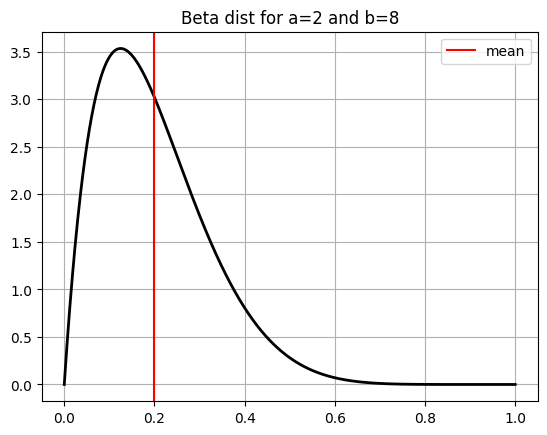

In [22]:
x = np.linspace(0, 1, 1000)
rv = stats.beta(a=2, b=8)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.axvline(x=mean, color='r', label='mean')
plt.title(r'Beta dist for a=2 and b=8')
plt.grid()
plt.legend()
plt.show()

In [23]:
%%writefile model_1.stan

generated quantities {
  int<lower=0> N = 50; 
  real<lower=0, upper=1> p = beta_rng(2, 8); 
  int<lower=0, upper=N> y = binomial_rng(N, p);
}


Overwriting model_1.stan


In [24]:
gen_quant = CmdStanModel(stan_file='model_1.stan')

INFO:cmdstanpy:compiling stan file /home/model_1.stan to exe file /home/model_1
INFO:cmdstanpy:compiled model executable: /home/model_1


In [ ]:
samples = gen_quant.sample(data={'N': 50}, 
                            fixed_param=True, 
                            iter_sampling=1000, 
                            iter_warmup=0, 
                            chains=1)

In [26]:
df = samples.draws_pd()
df.head()

,lp__,accept_stat__,N,p,y
0,0.0,0.0,50.0,0.117889,11.0
1,0.0,0.0,50.0,0.074733,3.0
2,0.0,0.0,50.0,0.144723,5.0
3,0.0,0.0,50.0,0.295479,19.0
4,0.0,0.0,50.0,0.116364,8.0


In [27]:
df['ratio'] = df.y / 50
ratio_mean = df['ratio'].mean()
ratio_mean

0.20084000000000002

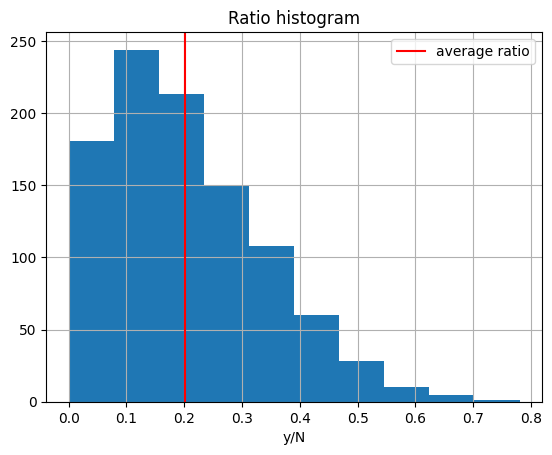

In [28]:
df['ratio'].hist(bins=10)
plt.axvline(x=ratio_mean, color ='r', label='average ratio')
plt.xlabel("y/N")
plt.title('Ratio histogram')
plt.legend()
plt.show()

### Modeling posterior and posterior predictive distribution

In [29]:
%%writefile model_2.stan

data {
  int<lower=0> N;
  int<lower=0, upper=N> y;
}

parameters {
  real<lower=0, upper=1> p;
}

model {
  p ~ beta(2, 8);
  y ~ binomial(N, p);
}

generated quantities {
  int<lower=0, upper=N> y_pred = binomial_rng(N, p);
}


Overwriting model_2.stan


In [30]:
gen_quant = CmdStanModel(stan_file='model_2.stan')

INFO:cmdstanpy:compiling stan file /home/model_2.stan to exe file /home/model_2
INFO:cmdstanpy:compiled model executable: /home/model_2


In [ ]:
samples = gen_quant.sample(data={'N': 50, 'y': 7})

In [35]:
df = samples.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,p,y_pred
0,-25.5849,1.000000,0.959557,1.0,1.0,0.0,26.0882,0.182434,7.0
1,-25.6935,0.882639,0.959557,1.0,3.0,0.0,26.4497,0.115121,4.0
2,-25.7131,0.996545,0.959557,1.0,1.0,0.0,25.7704,0.114181,6.0
3,-26.2155,0.958117,0.959557,2.0,7.0,0.0,26.2524,0.216535,12.0
4,-26.2155,0.345987,0.959557,1.0,1.0,0.0,28.4564,0.216535,9.0


In [51]:
ratios = df['y_pred'] / 50
ratios = ratios.to_numpy()

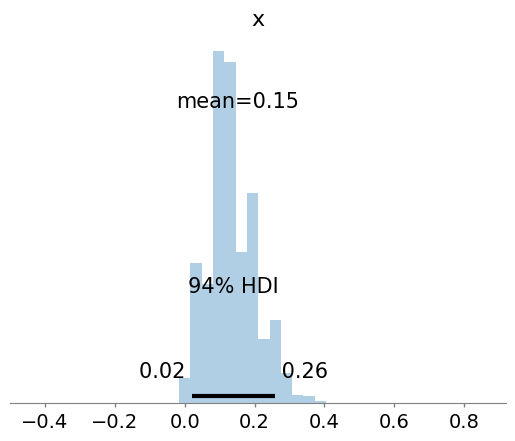

In [54]:
az.plot_posterior(ratios, kind='hist', hdi_prob=0.94, point_estimate='mean')
plt.show()

In [53]:
p = df['p'].to_numpy()

ratio_mean = np.mean(ratios)
ratio_hdi = az.hdi(ratios, hdi_prob=0.94)

p_mean = np.mean(p)
p_hdi = az.hdi(p, hdi_prob=0.94)

print(f"Predicted ratio: mean = {ratio_mean:.3f}, 94% HDI = {ratio_hdi}")
print(f"Parameter p: mean = {p_mean:.3f}, 94% HDI = {p_hdi}")

p_avg = 0.2
ratio_prob = np.mean(ratios < p_avg)

print(f"Probability that ratio is lower than average: {ratio_prob:.3f}")

Predicted ratio: mean = 0.151, 94% HDI = [0.02 0.26]
Parameter p: mean = 0.151, 94% HDI = [0.0658894 0.23596  ]
Probability that ratio is lower than average: 0.737
